# Bayesian Optimization with Gaussian Processes

This notebook shows an implementation of constrained and unconstrained Bayedian optimization using only numpy and scipy.  This is for educational purposes, and although it has a modest performance it is not build for speed. Hope it is useful. 

In [ ]:
# Authors:
# A. del Rio Chanona - Imperial College
# E. Bradford        - NTNU: Norwegian University of Science and Technology
# E. Sanchez Medina  - Imperial College
# P. Petsagkourakis  - University College London

# To cite please use the publications [1][2][3] at the bottom of the Notebook.

# Optimisation and Machine Learning for Process Systems Engineering: 
# https://www.imperial.ac.uk/optimisation-and-machine-learning-for-process-engineering/about-us/

# Other codes: https://www.imperial.ac.uk/optimisation-and-machine-learning-for-process-engineering/codes/

import numpy as np
import time
import numpy.random as rnd
from scipy.spatial.distance import cdist
!pip install sobol_seq
import sobol_seq
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## The Gaussian Process Model

Here is the GP model from scratch using only numpy and scipy. Bayesian optimization follows from this below.

## GP model

In [ ]:
class GP_model:
    
    ###########################
    # --- initializing GP --- #
    ###########################    
    def __init__(self, X, Y, kernel, multi_hyper, var_out=True):
        
        # GP variable definitions
        self.X, self.Y, self.kernel = X, Y, kernel
        self.n_point, self.nx_dim   = X.shape[0], X.shape[1]
        self.ny_dim                 = Y.shape[1]
        self.multi_hyper            = multi_hyper
        self.var_out                = var_out
        
        # normalize data
        self.X_mean, self.X_std     = np.mean(X, axis=0), np.std(X, axis=0)
        self.Y_mean, self.Y_std     = np.mean(Y, axis=0), np.std(Y, axis=0)
        self.X_norm, self.Y_norm    = (X-self.X_mean)/self.X_std, (Y-self.Y_mean)/self.Y_std
        
        # determine hyperparameters
        self.hypopt, self.invKopt   = self.determine_hyperparameters()        
    
    #############################
    # --- Covariance Matrix --- #
    #############################    
    
    def Cov_mat(self, kernel, X_norm, W, sf2):
        '''
        Calculates the covariance matrix of a dataset Xnorm
        --- decription ---
        '''
    
        if kernel == 'RBF':
            dist       = cdist(X_norm, X_norm, 'seuclidean', V=W)**2 
            cov_matrix = sf2*np.exp(-0.5*dist)
            return cov_matrix
            # Note: cdist =>  sqrt(sum(u_i-v_i)^2/V[x_i])
        else:
            print('ERROR no kernel with name ', kernel)

    ################################
    # --- Covariance of sample --- #
    ################################    
        
    def calc_cov_sample(self,xnorm,Xnorm,ell,sf2):
        '''
        Calculates the covariance of a single sample xnorm against the dataset Xnorm
        --- decription ---
        '''    
        # internal parameters
        nx_dim = self.nx_dim

        dist = cdist(Xnorm, xnorm.reshape(1,nx_dim), 'seuclidean', V=ell)**2
        cov_matrix = sf2 * np.exp(-.5*dist)

        return cov_matrix                
        
    ###################################
    # --- negative log likelihood --- #
    ###################################   
    
    def negative_loglikelihood(self, hyper, X, Y):
        '''
        --- decription ---
        ''' 
        # internal parameters
        n_point, nx_dim = self.n_point, self.nx_dim
        kernel          = self.kernel
        
        W               = np.exp(2*hyper[:nx_dim])   # W <=> 1/lambda
        sf2             = np.exp(2*hyper[nx_dim])    # variance of the signal 
        sn2             = np.exp(2*hyper[nx_dim+1])  # variance of noise

        K       = self.Cov_mat(kernel, X, W, sf2)  # (nxn) covariance matrix (noise free)
        K       = K + (sn2 + 1e-8)*np.eye(n_point) # (nxn) covariance matrix
        K       = (K + K.T)*0.5                    # ensure K is simetric
        L       = np.linalg.cholesky(K)            # do a cholesky decomposition
        logdetK = 2 * np.sum(np.log(np.diag(L)))   # calculate the log of the determinant of K the 2* is due to the fact that L^2 = K
        invLY   = np.linalg.solve(L,Y)             # obtain L^{-1}*Y
        alpha   = np.linalg.solve(L.T,invLY)       # obtain (L.T L)^{-1}*Y = K^{-1}*Y
        NLL     = np.dot(Y.T,alpha) + logdetK      # construct the NLL

        return NLL
    
    ############################################################
    # --- Minimizing the NLL (hyperparameter optimization) --- #
    ############################################################   
    
    def determine_hyperparameters(self):
        '''
        --- decription ---
        Notice we construct one GP for each output
        '''   
        # internal parameters
        X_norm, Y_norm  = self.X_norm, self.Y_norm
        nx_dim, n_point = self.nx_dim, self.n_point
        kernel, ny_dim  = self.kernel, self.ny_dim
        Cov_mat         = self.Cov_mat
        
        
        lb               = np.array([-4.]*(nx_dim+1) + [-8.])  # lb on parameters (this is inside the exponential)
        ub               = np.array([4.]*(nx_dim+1) + [ -2.])   # lb on parameters (this is inside the exponential)
        bounds           = np.hstack((lb.reshape(nx_dim+2,1),
                                      ub.reshape(nx_dim+2,1)))
        multi_start      = self.multi_hyper                   # multistart on hyperparameter optimization
        multi_startvec   = sobol_seq.i4_sobol_generate(nx_dim + 2,multi_start)

        options  = {'disp':False,'maxiter':10000}          # solver options
        hypopt   = np.zeros((nx_dim+2, ny_dim))            # hyperparams w's + sf2+ sn2 (one for each GP i.e. output var)
        localsol = [0.]*multi_start                        # values for multistart
        localval = np.zeros((multi_start))                 # variables for multistart

        invKopt = []
        # --- loop over outputs (GPs) --- #
        for i in range(ny_dim):    
            # --- multistart loop --- # 
            for j in range(multi_start):
                #print('multi_start hyper parameter optimization iteration = ',j,'  input = ',i)
                hyp_init    = lb + (ub-lb)*multi_startvec[j,:]
                # --- hyper-parameter optimization --- #
                res = minimize(self.negative_loglikelihood,hyp_init,args=(X_norm,Y_norm[:,i])\
                               ,method='SLSQP',options=options,bounds=bounds,tol=1e-12)
                localsol[j] = res.x
                localval[j] = res.fun

            # --- choosing best solution --- #
            minindex    = np.argmin(localval)
            hypopt[:,i] = localsol[minindex]
            ellopt      = np.exp(2.*hypopt[:nx_dim,i])
            sf2opt      = np.exp(2.*hypopt[nx_dim,i])
            sn2opt      = np.exp(2.*hypopt[nx_dim+1,i]) + 1e-8

            # --- constructing optimal K --- #
            Kopt        = Cov_mat(kernel, X_norm, ellopt, sf2opt) + sn2opt*np.eye(n_point)
            # --- inverting K --- #
            invKopt     += [np.linalg.solve(Kopt,np.eye(n_point))]

        return hypopt, invKopt

    ########################
    # --- GP inference --- #
    ########################     
    
    def GP_inference_np(self, x):
        '''
        --- decription ---
        '''
        nx_dim                   = self.nx_dim
        kernel, ny_dim           = self.kernel, self.ny_dim
        hypopt, Cov_mat          = self.hypopt, self.Cov_mat
        stdX, stdY, meanX, meanY = self.X_std, self.Y_std, self.X_mean, self.Y_mean
        calc_cov_sample          = self.calc_cov_sample
        invKsample               = self.invKopt
        Xsample, Ysample         = self.X_norm, self.Y_norm
        var_out                  = self.var_out
        # Sigma_w                = self.Sigma_w (if input noise)

        xnorm = (x - meanX)/stdX
        mean  = np.zeros(ny_dim)
        var   = np.zeros(ny_dim)
        # --- Loop over each output (GP) --- #
        for i in range(ny_dim):
            invK           = invKsample[i]
            hyper          = hypopt[:,i]
            ellopt, sf2opt = np.exp(2*hyper[:nx_dim]), np.exp(2*hyper[nx_dim])

            # --- determine covariance of each output --- #
            k       = calc_cov_sample(xnorm,Xsample,ellopt,sf2opt)
            mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
            var[i]  = max(0, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error
            #var[i] = sf2opt + Sigma_w[i,i]/stdY[i]**2 - np.matmul(np.matmul(k.T,invK),k) (if input noise)

        # --- compute un-normalized mean --- #    
        mean_sample = mean*stdY + meanY
        var_sample  = var*stdY**2
        
        if var_out:
            return mean_sample, var_sample
        else:
            return mean_sample.flatten()[0]

           

## Bayesian Optimization with Gaussian Processes

Gaussian processes are particulary efficient to optimize expensive black box functions (see [3]). The problem we wish to solve is the following:

$$\min_{{\bf x} \in \mathcal{X}} f({\bf x})$$

where ${\bf x} \in \mathbb{R}^{n_x}$

Generally, we wish our optimization problem wo have the following properties if we wish to solve it efficiently by Bayesian optimization with Gaussian processes:

*   In general, we assume $f$ is continous.
*   This framework generally works well in low and middle sized dimension spaces, say $n_x \leq 30$
*   The feasible set $\mathcal{X}$ is a simple set, in which it is easy to assess membership. For example, boxed-constrained (i.e. $x_i^{lb} \le x_i \le x_i^{ub}$).

The **general idea** is that we will be using a Gaussian process to model the objective function $f$. This will be done by sampling the objective function and creating a *surrogate* function $\hat{f}_{\mathcal{GP}}$ which we will optimize. Subsequently, we will sample our objective function $f$ again, and then refine the model of our objective function $\hat{f}_{\mathcal{GP}}$ and then optimize it again. This will be done iteratively until a covergence criterion is achieved.  

### Bayesian Optimization with Gaussian Processes algorithm

1.   **Initialization**: sample the objective function $f$ a number $n_s$ of times and produce $\hat{f}_{\mathcal{GP}}$, set number of iterations $N$, set $n:=0$.
2.   **while** $i \leq N$:
    *   a) Solve the optimization problem ${\bf x}_i^* := \text{argmin}_{{\bf x} \in \mathcal{X}} \hat{f}_{\mathcal{GP}}({\bf x})$
    *   b) Sample the objective function $f$ at point ${\bf x}_i^*$ and collect $y_i:=f({\bf x}_i^*)$
    *   c) add ${\bf x}_i^*$ and $y_i$ to the training data for the GP
    *   d) Update the Gaussian process with the new available data to model $\hat{f}_{\mathcal{GP}}$
    *   d) $i:= i + 1$

**Remarks**
*   A prior can be placed on $f$ (which might even be a model of the system)
*   The GP can be updated in step 2d in many ways with varying levels of sophistication. From rebuilding the GP from scratch with the new data, to updating only the covariance matrix and leaving the same hyperparameters, to other more complex (and efficient) updating strategies.
*   The surrogate objective function can take many forms. A simple and naive alternative would be to set it as the mean value of the Gaussian process prediction (i.e. $\hat{f}_{\mathcal{GP}}:=\mu_{\mathcal{GP}}$), we could also add an exploratory term, by including the variance (e.g. $\hat{f}_{\mathcal{GP}}:=\mu_{\mathcal{GP}}-\alpha \sigma_{\mathcal{GP}}$), where $\alpha$ is a weighting parameter, we could also make the GP convervative (e.g. $\hat{f}_{\mathcal{GP}}:=\mu_{\mathcal{GP}}+\alpha \sigma_{\mathcal{GP}}$). Some popular alternatives are *Expected Improvement*, *Knowledge Gradient*, and *Entropy Search*. 




## GP optimizer

In [ ]:
class GP_optimizer:
    
    ###########################
    # --- initializing GP --- #
    ###########################  
    
    def __init__(self, obj_f, data, iter_opt, bounds, multi_opt=4, multi_hyper=10, store_data=False):
        '''
        data = ['int', bound_list=[[0,10],[-5,5],[3,8]], samples_number] <=> d = ['int', np.array([[-12, 8]]), 3]
        data = ['data0', data=[Xtrain,ytrain]]
        Note 1: in GP_obj_f we define the objective as only the mean or with the variance
        '''
        print('- Note: GP_optimizer works for unconstrained one output GP optimization')
        
        # GP variable definitions
        self.obj_f, self.data, self.store_data = obj_f, data, store_data
        self.multi_hyper, self.multi_opt       = multi_hyper, multi_opt
        self.iter_opt, self.bounds             = iter_opt, bounds
        # data creating
        self.Xtrain, self.ytrain               = self.data_handling()
        self.ndim, self.ndat                   = self.Xtrain.shape[1], self.Xtrain.shape[0]
        
     
    #########################
    # --- training data --- #
    #########################
        
    def data_handling(self):
        '''
        --- description ---
        '''
        data = self.data
        
        # Training data
        if data[0]=='int':
            print('- No preliminar data supplied, computing data by sobol sequence')
            Xtrain, ytrain = self.compute_data(data)
            return Xtrain, ytrain

        elif data[0]=='data0':
            print('- Training data has been suplied')
            Xtrain = data[1][0]
            ytrain = data[1][1]
            return Xtrain, ytrain

        else:
            print('- error, data ragument ',data,' is of wrong type; can be int or ')
            return None 
    
    ##########################
    # --- computing data --- #
    ##########################
    
    def compute_data(self, data):
        '''
        --- description ---
        '''
        # internal variable calls
        obj_f, ndata = self.obj_f, data[2]
        ndim         = data[1].shape[0]
        x_max, x_min = data[1][:,1], data[1][:,0]
        
        # computing data
        fx     = np.zeros(ndata)
        xsmpl  = sobol_seq.i4_sobol_generate(ndim, ndata) # xsmpl.shape = (ndat,ndim)
        
        Xtrain = np.zeros((ndata, ndim))
        # computing Xtrain
        for i in range(ndata):
            xdat        = x_min + xsmpl[i,:]*(x_max-x_min)
            Xtrain[i,:] = xdat

        for i in range(ndata):
            fx[i] = obj_f(Xtrain[i,:])

        # not meant for multi-output
        ytrain = fx.reshape(ndata,1)
           
        Xtrain = np.array(Xtrain)
        ytrain = np.array(ytrain)
        
        return Xtrain.reshape(ndata,ndim, order='F'), ytrain.reshape(ndata,1)

    ##############################
    # --- GP as obj function --- #
    ##############################
    
    def GP_obj_f(self, x, GP, obj=2):
        '''
        define exploration - explotation strategy
        '''
        # internal variable calls
        if obj == 1:
            obj_f = GP.GP_inference_np(x)
            return obj_f[0]
        
        elif obj == 2:
            obj_f = GP.GP_inference_np(x)
            return obj_f[0] - 3*np.sqrt(obj_f[1]) 
        
        else:
            print('error, objective for GP not specified')
            
    ########################################
    # --- Creating storing data arrays --- #
    ########################################   
    
    def create_data_arrays(self): 
        '''
        --- description ---
        '''
        # internal variable calls
        store_data, iter_opt = self.store_data, self.iter_opt
        ndim, bounds         = self.ndim, self.bounds
        
        if store_data == True:
            print('- remember: store data only available for 1-dimension')
            ntest = 100 # number of samples for trajectory
            Xtest_l = np.zeros((ntest,ndim))                # only 1D supported
            Xtest_l = np.linspace(bounds[0][0], bounds[0][1], num=ntest).reshape(ntest,ndim, order='F')
            ymean_l = np.zeros((iter_opt+1,ntest))
            ystd_l  = np.zeros((iter_opt+1,ntest))
            return Xtest_l, ymean_l, ystd_l
        
        elif store_data == False:
            return 'NA', 'NA', 'NA'
        
    ########################
    # --- Storing data --- #
    ########################   
    
    def add_data(self, Xtest_l, ymean_l, ystd_l, i_opt, GP_m): 
        '''
        --- description ---
        '''     
        store_data =  self.store_data
        
        if store_data == True:
            # internal variable calls
            GP_obj_f, obj_f     = self.GP_obj_f, self.obj_f
            ntest               = Xtest_l.shape[0]
            
            # -- loop to compute GP prediction -- #
            for ii in range(n_test):
                m_ii, std_ii   = GP_m.GP_inference_np(Xtest_l[ii,:])
                ymean_l[i_opt,ii] = m_ii 
                ystd_l[i_opt,ii]  = std_ii        
            return ymean_l, ystd_l
        
        elif store_data == False:
            return 'NA', 'NA'
    
    ############################
    # --- Optimization alg --- #
    ############################   
    
    def optimization_routine(self):
        '''
        --- description ---
        '''
        # internal variable calls
        store_data, Xtrain, ytrain   = self.store_data, self.Xtrain, self.ytrain
        multi_hyper, iter_opt        = self.multi_hyper, self.iter_opt
        ndim, ndat, obj_f, multi_opt = self.ndim, self.ndat, self.obj_f, self.multi_opt
        GP_obj_f, add_data, bounds   = self.GP_obj_f, self.add_data, self.bounds
        create_data_arrays           = self.create_data_arrays
        
        # building the first GP model
        GP_m   = GP_model(Xtrain, ytrain, 'RBF', multi_hyper=multi_hyper, var_out=True)
        X_opt  = Xtrain
        y_opt  = ytrain
        
        # --- storing data --- #
        Xtest_l, ymean_l, ystd_l = create_data_arrays()        
        
        # --- optimization loop --- #
        options          = {'disp':False,'maxiter':10000}  # solver options
        lb, ub           = bounds[:,0], bounds[:,1]
        multi_startvec   = sobol_seq.i4_sobol_generate(ndim,multi_opt)
        
        # optimization -- iterations
        for i_opt in range(iter_opt):
            print('optimization interation ',i_opt)
            # --- storing data --- #
            ymean_l, ystd_l = add_data(Xtest_l, ymean_l, ystd_l, i_opt, GP_m)
            
            localsol = [0.]*multi_opt           # values for multistart
            localval = np.zeros((multi_opt))    # variables for multistart
            
            # optimization -- multistart
            for j in range(multi_opt):
                #print('iter ',i_opt,'  multistart ',j)
                x_init    = lb + (ub-lb)*multi_startvec[j,:]
                # GP optimization
                res = minimize(GP_obj_f, x_init, args=(GP_m), method='SLSQP',
                               options=options, bounds=bounds, tol=1e-12)
                localsol[j] = res.x
                if res.success == True:
                    localval[j] = res.fun
                else:
                    localval[j] = np.inf
            if np.min(localval) == np.inf:
                print('warming, no feasible solution found')
            minindex    = np.argmin(localval) # choosing best solution
            xnew        = localsol[minindex]  # selecting best solution

            xnew   = np.array([xnew]).reshape(1,ndim)
            ynew   = obj_f(xnew)
            # adding new point to sample
            X_opt  = np.vstack((X_opt,xnew))
            y_opt  = np.vstack((y_opt,ynew))
            # re-training GP
            GP_m   = GP_model(X_opt, y_opt, 'RBF', multi_hyper=10, var_out=True)
            
        # --- storing data --- #
        ymean_l, ystd_l = add_data(Xtest_l, ymean_l, ystd_l, i_opt+1, GP_m)
        
        if store_data == False:
            return X_opt, y_opt
        elif store_data == True:
            return X_opt, y_opt, Xtest_l, ymean_l, ystd_l
    

## 1D optimization problem

### Function to be optimized

In [ ]:
def gaussian_func(gaus_func, x):
    '''
    Computes values for multiple gaussians
    --- decription ---
    gaus_func:     list of gaussians with pre exponential, std and mean
    x:             point of evaluation
    input example: gaus_func = [[5.,1.,0],[1.,3.,2.]], x = 2.
    ''' 
    eval = 0
    
    for gi in gaus_func:
        a, std, m = gi
        eval += a/(std*2.5)*np.exp(-0.5*((x-m)/std)**2)   

    return -eval

def gaus3_func(x):
    '''
    function that is the sum of 3 gaussians
    ''' 

    return gaussian_func([[1.,2.,-8.],[1.5,1.5,0.],[1.4,1.,5.]],x)
    

#### Looking ta the function

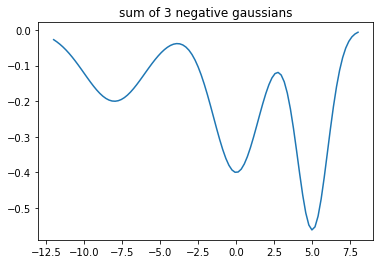

In [ ]:
# --- plot initial function --- #

n_test      = 100
xtest       = np.linspace(-12, 8, num=n_test)
ftect       = np.zeros(n_test)
for i in range(n_test):
    ftect[i] = gaus3_func(xtest[i])
    
# plot observed points
plt.plot(xtest, ftect)

plt.title('sum of 3 negative gaussians')
plt.show()

#### Initial GP fit of function

In [ ]:
# --- Initial sampling --- #
Xtrain = np.array([-10.,-7,-3, 0., 4., 5.5])
#Xtrain = np.array([-11,-10,-9,-8,-7,-6,-5,-4 -1,3,6, 7.5])
ndata  = Xtrain.shape[0]
Xtrain = Xtrain.reshape(ndata,1)
fx     = np.zeros(ndata)

for i in range(ndata):
    fx[i] = gaus3_func(Xtrain[i,0])

eps    = np.random.normal(0, 1e-3, ndata)
ytrain = fx.reshape(ndata,1) + eps.reshape(ndata,1)

# --- build a GP model --- #
GP_m = GP_model(Xtrain, ytrain, 'RBF', multi_hyper=10, var_out=True)

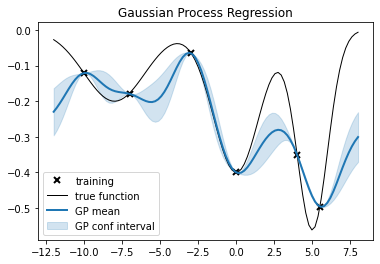

In [ ]:
# --- use GP to predict test data --- #
Xtest       = np.linspace(-12.0, 8.0, num=n_test)
Ytest_mean  = np.zeros(n_test)
Ytest_std   = np.zeros(n_test)

for ii in range(n_test):
    m_ii, std_ii   = GP_m.GP_inference_np(Xtest[ii])
    Ytest_mean[ii] = m_ii 
    Ytest_std[ii]  = std_ii
    
# --- Plotting --- #

# plot observed points
plt.plot(Xtrain, ytrain, 'kx', mew=2)

# plot the samples of posteriors
plt.plot(xtest, ftect, 'black', linewidth=1)

# plot GP confidence intervals
plt.gca().fill_between(Xtest.flat, 
                       Ytest_mean - 3*Ytest_std, 
                       Ytest_mean + 3*Ytest_std, 
                       color='C0', alpha=0.2)

# plot GP mean
plt.plot(Xtest, Ytest_mean, 'C0', lw=2)

plt.title('Gaussian Process Regression')
plt.legend(('training', 'true function', 'GP mean', 'GP conf interval'),
           loc='lower left')
plt.show()

- Note: GP_optimizer works for unconstrained one output GP optimization
- Training data has been suplied
- remember: store data only available for 1-dimension
optimization interation  0
optimization interation  1
optimization interation  2
optimization interation  3
optimization interation  4
optimization interation  5
optimization interation  6
optimization interation  7


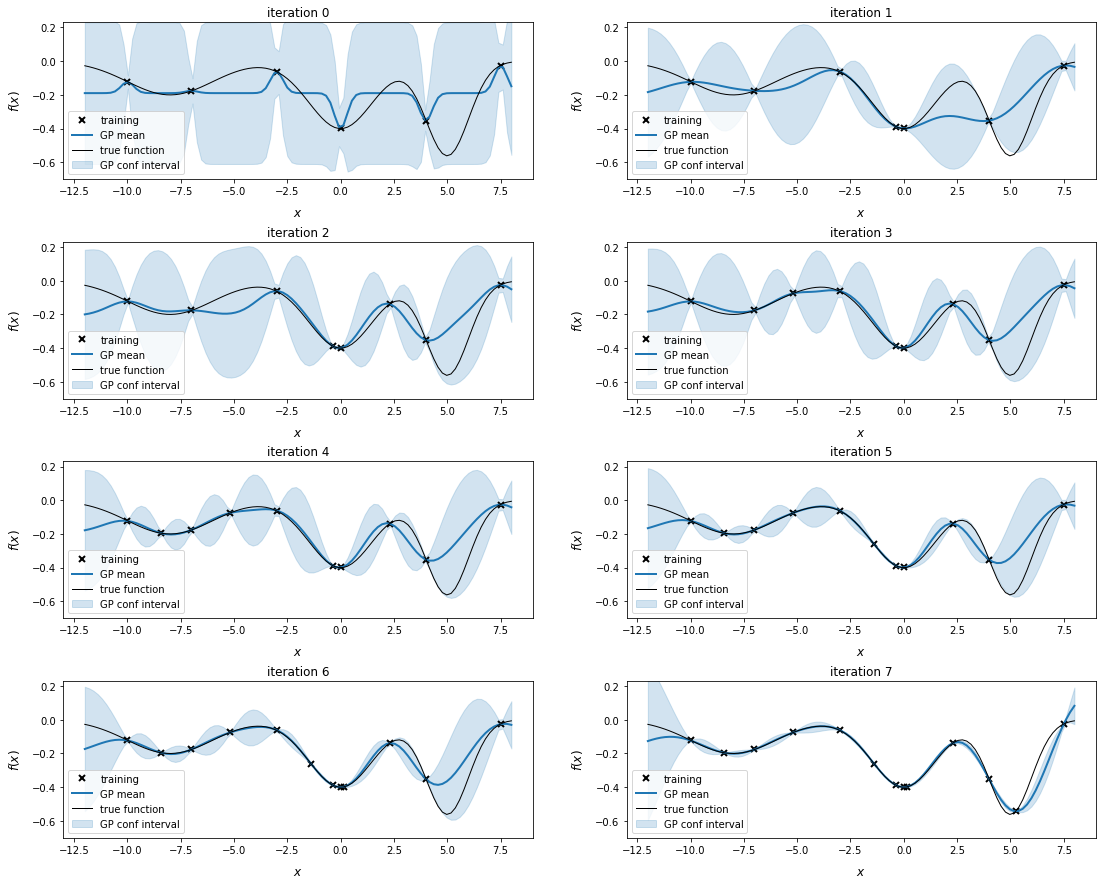

In [ ]:


# %%%%%% computing data %%%%%% #

# --- defining Xtrain --- #
Xtrain = np.array([-10.,-7,-3, 0., 4., 7.5])
ndata  = Xtrain.shape[0]
Xtrain = Xtrain.reshape(ndata,1)
fx     = np.zeros(ndata)

# --- computing ytrain --- #
for i in range(ndata):
    fx[i] = gaus3_func(Xtrain[i,0])
eps    = np.random.normal(0, 1e-3, ndata)
ytrain = fx.reshape(ndata,1) + eps.reshape(ndata,1)

# --- joining Xtrain + ytrain --- #
d = ['data0', [Xtrain,ytrain]]

# %%%%%% optimization %%%%%% #
opt_iteations = 8

GP_opt = GP_optimizer(gaus3_func, d, opt_iteations, np.array([[-12.0, 8.0]]), store_data=True)
X_, Y_, Xtest_l, ymean_l, ystd_l = GP_opt.optimization_routine()



# %%%%%% Plotting %%%%%% #
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# --- real function point --- #
n_test      = 100
xtest       = np.linspace(-12, 8, num=n_test)
ftect       = np.zeros(n_test)
for i in range(n_test):
    ftect[i] = gaus3_func(xtest[i])

# --- plot loop --- #
fig = plt.figure()
fig.set_size_inches(18.5, 15.)

for ik in range(opt_iteations):
    
    # setting up plot
    ax = fig.add_subplot(int(opt_iteations/2.), 2, ik+1)

    # labels and titles
    ax.set_title('iteration '+str(ik), fontsize=12)
    ax.set_xlabel(r'$\mathit{x}$', fontsize=12, labelpad=10)
    ax.set_ylabel(r'$\mathit{f(x)}$', fontsize=12, labelpad=10)

    # Plot scattered training points
    ax.plot(X_[:ndata+ik], Y_[:ndata+ik], 'kx', mew=2)

    # plot GP mean
    ax.plot(Xtest_l[:,0], ymean_l[ik,:], 'C0', lw=2)

    # plot real function
    ax.plot(xtest, ftect, 'black', linewidth=1)

    # plot GP confidence intervals
    plt.gca().fill_between(Xtest_l[:,0], 
                       ymean_l[ik,:] - 3*np.sqrt(ystd_l[ik,:]), 
                       ymean_l[ik,:] + 3*np.sqrt(ystd_l[ik,:]), 
                       color='C0', alpha=0.2)

    ax.legend(('training', 'GP mean', 'true function', 'GP conf interval'),
               loc='lower left')
    plt.gca().set_ylim([-0.7, 0.23])
fig.subplots_adjust(hspace=0.4)
plt.show()


## 2D optimization problem

### Function to be optimized: Rosenbrock function

In [ ]:
def rosenbrock(x):
    x = x.squeeze()
    if len(x.shape) == 1:
        #return sum([100*(x[i+1]-x[i])**2 + (1-x[i])**2 for i in range(x.shape[0]-1) ])
        return np.log(sum([100*(x[i+1]-x[i])**2 + (1-x[i])**2 for i in range(x.shape[0]-1) ]) ) # notice this makes a difference
    else:
        return 100*(x[1,:]-x[0,:])**2 + (1-x[0,:])**2

### Visualizing the function

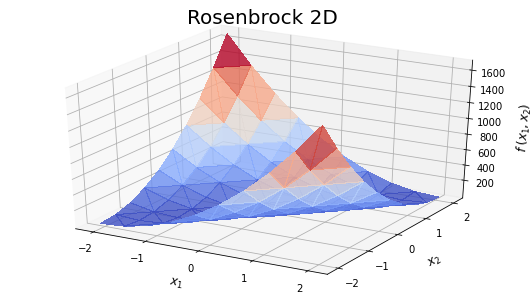

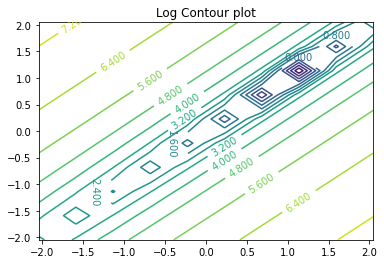

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Plot a sin curve using the x and y axes.
n_points = 10
x_1      = np.linspace(-2.048, 2.048, n_points)
x_2      = np.linspace(-2.048, 2.048, n_points)
x        = [[x,y] for x in x_1 for y in x_2]
x        = np.array(x)
x        = x.T
f        = rosenbrock(x)

# importing libraries
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# setting up plot
plt = matplotlib.pyplot
fig = plt.figure()
fig.set_size_inches(18.5/2, 10.5/2)
ax = fig.add_subplot(111, projection='3d')

# labels and titles
plt.title('Rosenbrock 2D ', fontsize=20)
ax.set_xlabel(r'$\mathit{x_1}$', fontsize=12, labelpad=10)
ax.set_ylabel(r'$\mathit{x_2}$', fontsize=12, labelpad=10)
ax.set_zlabel(r'$\mathit{f\;(x_1,x_2)}$', fontsize=12, labelpad=10)


# plot
ax.plot_trisurf(x[0,:], x[1,:], f, cmap=cm.coolwarm, 
                linewidth=0, antialiased=False, alpha=0.8)
plt.show()

# Contour plot
f_copy = f.reshape((n_points,n_points), order='F')

fig, ax = plt.subplots()
CS = ax.contour(x_1, x_2, np.log(f_copy), 15)
#ax.clabel(CS, inline=1, fontsize=10)
ax.clabel(CS, fontsize=10)
ax.set_title('Log Contour plot')
plt.show()

In [ ]:
opt_iteations = 20
bound_list    = np.array([[-1.5, 1.5],[-1.5, 1.5]])
d             = np.array(['int', bound_list, 20])

GP_opt        = GP_optimizer(rosenbrock, d, opt_iteations, bound_list, multi_opt=30, store_data=False)
X_opt, y_opt  = GP_opt.optimization_routine()
print('optimal value found: x = ',X_opt[np.argmin(y_opt),:],' y = ',np.exp(np.min(y_opt)))

- Note: GP_optimizer works for unconstrained one output GP optimization
- No preliminar data supplied, computing data by sobol sequence
optimization interation  0
optimization interation  1
optimization interation  2
optimization interation  3
optimization interation  4
optimization interation  5
optimization interation  6
optimization interation  7
optimization interation  8
optimization interation  9
optimization interation  10
optimization interation  11
optimization interation  12
optimization interation  13
optimization interation  14
optimization interation  15
optimization interation  16
optimization interation  17
optimization interation  18
optimization interation  19
optimal value found: x =  [1.125 1.125]  y =  0.015625000000000007


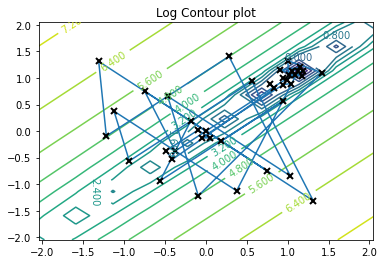

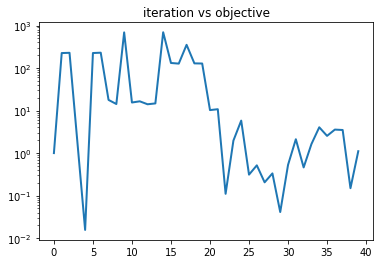

In [ ]:
# Contour plot
f_copy = f.reshape((n_points,n_points), order='F')

fig, ax = plt.subplots()
CS = ax.contour(x_1, x_2, np.log(f_copy), 15)
#ax.clabel(CS, inline=1, fontsize=10)
ax.clabel(CS, fontsize=10)
ax.plot(X_opt[:,0], X_opt[:,1], '-')
ax.plot(X_opt[:,0], X_opt[:,1], 'kx', mew=2)
ax.set_title('Log Contour plot')
plt.show()

# plot objective
fig, ax = plt.subplots()
ax.plot(np.exp(y_opt), '-', lw=2)
ax.set_yscale('log')
plt.title('iteration vs objective')
plt.show()

# Constrained Bayesian Optimization with Gaussian Processes

It is also possible to use Gaussian processes to solve optimization problems that involve expensive black-box objective functions and constraints. The key difference here is that there are also constraints which we must satisfy. Therefore, constraints are also estimated and substitted by surrogate constraints. In this notebook we have used Gaussian processes also as surrogates for the constraints, but any other function can be used as well. The problem we wish to solve is now:

$$\min_{{\bf x} \in \mathcal{X}} f({\bf x})$$
subject to:
$${\bf g}({\bf x}) \leq {\bf 0}$$

where ${\bf x} \in \mathbb{R}^{n_x}$ and ${\bf g}:\mathbb{R}^{n_x} \rightarrow \mathbb{R}^{n_g}$

In this case, the collected samples $X = \left[{\bf x}_1^T, ...,{\bf x}_{n_s}^T  \right]$ are used to construct surrogate functions of $f$ and for ${\bf g}$, and therefore yield the following optimization problem:

$$\min_{{\bf x} \in \mathcal{X}} \hat{f}_{\mathcal{GP}}({\bf x})$$
subject to:
$${\bf \hat{g}_{\mathcal{GP}}}({\bf x}) \leq {\bf 0}$$

The basic algorithm is very similar to that of the unconstrained problem, with the only difference that there are surrogates for constraints also. However, these problems having constraints open for a huge range of possible problem instances, and therefore complexity on solutions methods. For example, can constraints be violated during the search for an optimal solution, or is violating constraints even in intermediate steps inconvinient or even dangerous? We do not explore this further here, however, it is decribed in [1]. In this notebook we show the code implementation for the "simple" case shown above.

In [ ]:
class N_GP_RTO:
    
    ###################################
    # --- initializing ITR_GP_RTO --- #
    ###################################  
    
    def __init__(self, obj_f, constraints, n_iter, data, bounds, multi_opt=10, multi_hyper=10, store_data=True):
        '''
        data = ['int', bound_list=[[0,10],[-5,5],[3,8]], samples_number] <=> d = ['int', np.array([[-12, 8]]), 3]
        data = ['data0', Xtrain]
        
        Note 1: remember the data collected 
        
        '''
        
        # intrnal variable definitions
        self.obj_f, self.constraints, self.n_iter = obj_f, constraints, n_iter
        self.multi_opt, self.multi_hyper          = multi_opt, multi_hyper
        self.store_data, self.data, self.bounds   = store_data, data, bounds
        
        # other definitions
        self.ng = len(constraints)
        # data creating
        self.Xtrain, self.ytrain               = self.data_handling()
        self.ndim, self.ndat                   = self.Xtrain.shape[1], self.Xtrain.shape[0]
        # alerts
        print('note: remember constraints are set as positive, so they should be set as -g(x)')
        
     
    #########################
    # --- training data --- #
    #########################
        
    def data_handling(self):
        '''
        --- description ---
        '''
        data = self.data
        
        # Training data
        if data[0]=='int':
            print('- No preliminar data supplied, computing data by sobol sequence')
            Xtrain         = None
            Xtrain, ytrain = self.compute_data(data, Xtrain)
            return Xtrain, ytrain

        elif data[0]=='data0':
            print('- preliminar data supplied, computing objective and constraint values')
            Xtrain         = data[1]
            Xtrain, ytrain = self.compute_data(data, Xtrain)
            return Xtrain, ytrain

        else:
            print('- error, data ragument ',data,' is of wrong type; can be int or ')
            return None 
        
    ##########################
    # --- computing data --- #
    ##########################
    
    def compute_data(self, data, Xtrain):
        '''
        --- description ---
        '''
        # internal variable calls
        obj_f, ndata, constraints = self.obj_f, data[2], self.constraints
        data[1]                   = np.array(data[1])
        ndim, ng                  = data[1].shape[0], self.ng
        x_max, x_min              = data[1][:,1], data[1][:,0]
        
        if Xtrain == None: # no data suplied
            # data arrays
            Xtrain = np.zeros((ndata, ndim))
            ytrain = np.zeros((ng+1, ndata))
            funcs  = [obj_f]+constraints

            for ii in range(ng+1):
                # computing data
                fx     = np.zeros(ndata)
                xsmpl  = sobol_seq.i4_sobol_generate(ndim, ndata) # xsmpl.shape = (ndat,ndim)

                # computing Xtrain
                for i in range(ndata):
                    xdat        = x_min + xsmpl[i,:]*(x_max-x_min)
                    Xtrain[i,:] = xdat
                for i in range(ndata):
                    fx[i] = funcs[ii](*Xtrain[i,:])
                # not meant for multi-output
                ytrain[ii,:] = fx
                
        else: # data suplied
            # data arrays
            ytrain = np.zeros((ng+1, ndata))
            funcs  = [obj_f]+constraints

            for ii in range(ng+1):
                fx     = np.zeros(ndata)
                
                for i in range(ndata):
                    fx[i] = funcs[ii](Xtrain[i,:])
                # not meant for multi-output
                ytrain[ii,:] = fx
            
        Xtrain = np.array(Xtrain)
        ytrain = np.array(ytrain)
        
        return Xtrain.reshape(ndata, ndim, order='F'), ytrain.reshape(ng+1, ndata, order='F')
    
    ##############################
    # --- GP as obj function --- #
    ##############################
    
    def GP_obj_f(self, x, GP, obj=2):
        '''
        define exploration - explotation strategy
        '''
        # internal variable calls
        if obj == 1:
            obj_f = GP.GP_inference_np(x)
            return obj_f[0]
        
        elif obj == 2:
            obj_f = GP.GP_inference_np(x)
            return obj_f[0] - 2*np.sqrt(obj_f[1]) 
        
        else:
            print('error, objective for GP not specified')
    
    ######################################
    # --- Real-Time Optimization alg --- #
    ######################################   
    
    def RTO_routine(self):
        '''
        --- description ---
        '''
        # internal variable calls
        store_data, Xtrain, ytrain   = self.store_data, self.Xtrain, self.ytrain
        multi_hyper, n_iter          = self.multi_hyper, self.n_iter
        ndim, ndat, obj_f, multi_opt = self.ndim, self.ndat, self.obj_f, self.multi_opt
        GP_obj_f, bounds, ng         = self.GP_obj_f, self.bounds, self.ng
        multi_opt, constraints       = self.multi_opt, self.constraints
        
        # variable definitions
        funcs  = [obj_f]+constraints
        
        # building the first GP model
        n_dpts   = Xtrain.shape[0]
        GP_obj   = GP_model(Xtrain, ytrain[0,:].reshape(n_dpts,1), 'RBF', multi_hyper=multi_hyper, var_out=True)
        GP_con   = [0]*ng
        GP_con_f = [0]*ng
        for igp in range(ng):
            GP_con[igp]   = GP_model(Xtrain, ytrain[igp+1,:].reshape(n_dpts,1), 
                                     'RBF', multi_hyper=multi_hyper, var_out=False)  
            GP_con_f[igp] = {'type': 'ineq', 'fun': GP_con[igp].GP_inference_np}
        
        X_opt       = Xtrain
        y_opt       = ytrain     
        
        # --- rto loop --- #
        options          = {'disp':False,'maxiter':10000}  # solver options
        lb, ub           = bounds[:,0], bounds[:,1]
        multi_startvec   = sobol_seq.i4_sobol_generate(ndim,multi_opt)
        
        # rto -- iterations
        for i_rto in range(n_iter):
            print('============================ RTO iteration ',i_rto)
            
            localsol = [0.]*multi_opt           # values for multistart
            localval = np.zeros((multi_opt))    # variables for multistart
            
            # optimization -- multistart
            for j in range(multi_opt):
                #print('iter ',i_opt,'  multistart ',j)
                x_init     = lb + (ub-lb)*multi_startvec[j,:]
                opt_method = 'COBYLA'#'COBYLA','SLSQP', 'trust-constr'
                # GP optimization
                
                res = minimize(GP_obj_f, x_init, args=(GP_obj), method=opt_method,
                               options=options, bounds=bounds, constraints=GP_con_f, tol=1e-12)
                localsol[j] = res.x
                if res.success == True:
                    localval[j] = res.fun
                else:
                    localval[j] = np.inf
            if np.min(localval) == np.inf:
                print('warming, no feasible solution found')
            minindex    = np.argmin(localval) # choosing best solution
            xnew        = localsol[minindex]  # selecting best solution
            
            # re-evaluate best point (could be done more efficiently - no re-evaluation)
            xnew = np.array([xnew]).reshape(1,ndim)
            ynew = np.zeros((1,ng+1)) 
            for ii in range(ng+1):                   
                ynew[0,ii] = funcs[ii](*xnew.flatten()[:])
                
            # adding new point to sample
            X_opt  = np.vstack((X_opt,xnew))
            y_opt  = np.hstack((y_opt,ynew.T))
            
            # --- re-training GP --- #
            n_dpts  = Xtrain.shape[0]
            GP_obj  = GP_model(X_opt, y_opt[0,:].reshape(n_dpts+i_rto+1,1), 'RBF', multi_hyper=multi_hyper, var_out=True)
            GP_con  = [0]*ng
            for igp in range(ng):
                GP_con[igp] = GP_model(X_opt, y_opt[igp+1,:].reshape(n_dpts+i_rto+1,1), 'RBF', multi_hyper=multi_hyper, var_out=False)
            self.GP_con = GP_con
            
        # --- output data --- #
        return X_opt, y_opt    

## Easy Objective function (Convex)

In [ ]:
def quadratic_function(x,y):
    f = (x-1.)**2 + 10*(y+1.)**2 
    return f

def con_simple1(x,y):
    g1 = x + y - 2.        
    return -g1

def con_simple2(x,y):
    g2 = (x - y)**2 - 4.
    return -g2

In [ ]:
constraints         = [con_simple1, con_simple2]
obj_f               = quadratic_function
n_iter              = 10
bounds              = [[-5.,5.],[-5.,5.]]
samples_number      = 10
data                = ['int', bounds, samples_number]

N_GP_opt             = N_GP_RTO(obj_f, constraints, n_iter, data, np.array(bounds), 
                                multi_opt=10, multi_hyper=5, store_data=True)
X_opt, y_opt = N_GP_opt.RTO_routine()

- No preliminar data supplied, computing data by sobol sequence
note: remember constraints are set as positive, so they should be set as -g(x)
============================ RTO iteration  0


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:528: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)


============================ RTO iteration  1
============================ RTO iteration  2
============================ RTO iteration  3
============================ RTO iteration  4
============================ RTO iteration  5
============================ RTO iteration  6
============================ RTO iteration  7
============================ RTO iteration  8
============================ RTO iteration  9


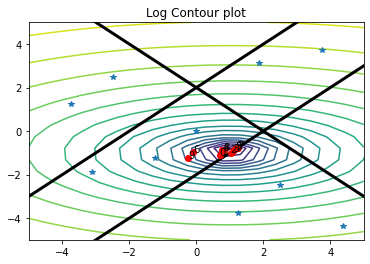

In [ ]:
# Plot a sin curve using the x and y axes.
n_points = 20
x_1      = np.linspace(-5.,5., n_points)
x_2      = np.linspace(-5.,5., n_points)
x        = [[x,y] for x in x_1 for y in x_2]
x        = np.array(x)
x        = x.T

# --- plotting functions --- #

# plotting objective
def simplefunc_plot(x):
    return (x[0,:]-1.)**2 + 5*(x[1,:]+1.)**2
f = simplefunc_plot(x)
# plotting constraint g1
g1x2Simple_plot = [2-x for x in x_1]
# plotting constraint g2
g21x2Simple_plot = [-2+x for x in x_1]
g22x2Simple_plot = [+2+x for x in x_1]

# Contour plot
f_copy = f.reshape((n_points,n_points),order='F')

fig, ax = plt.subplots()
CS = ax.contour(x_1, x_2, np.log(f_copy), 20)
ax.plot(x_1, g1x2Simple_plot, 'black', linewidth=3)
ax.plot(x_1, g21x2Simple_plot, 'black', linewidth=3)
ax.plot(x_1, g22x2Simple_plot, 'black', linewidth=3)
ax.plot(X_opt[samples_number:,0], X_opt[samples_number:,1], 'ro')
ax.plot(X_opt[:samples_number,0], X_opt[:samples_number,1], '*')
for i in range(X_opt[samples_number:,:].shape[0]):
    plt.text(X_opt[samples_number+i,0], X_opt[samples_number+i,1], str(i))
#ax.clabel(CS, fontsize=10)
ax.set_title('Log Contour plot')
plt.axis([-5,5, -5,5])
plt.show()

## Second Example problem (difficult - nonconvex)

### Bohachevsky function

In [ ]:
def BOHACHEVSKY(x,y):
    f = x**2 + 2*y**2 - 0.3*np.cos(3*np.pi*x) - 0.4*np.cos(4*np.pi*y) +0.7  
    return f

def con1B(x,y):
    g1 = x + y - 0.#1.9        
    return -g1

def con2B(x,y):
    #g2 = x + y - 3.
    g2 = (x - 1.)**3 - y + 1
    return -g2

- No preliminar data supplied, computing data by sobol sequence
note: remember constraints are set as positive, so they should be set as -g(x)
============================ RTO iteration  0


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:528: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)


============================ RTO iteration  1
============================ RTO iteration  2
============================ RTO iteration  3
============================ RTO iteration  4
============================ RTO iteration  5
============================ RTO iteration  6
============================ RTO iteration  7
============================ RTO iteration  8
============================ RTO iteration  9
============================ RTO iteration  10
============================ RTO iteration  11
============================ RTO iteration  12
============================ RTO iteration  13
============================ RTO iteration  14


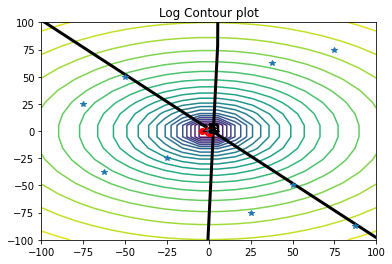

In [ ]:
constraints         = [con1B, con2B]
obj_f               = BOHACHEVSKY
n_iter              = 15
bounds              = [[-100.,100.],[-100.,100.]]
samples_number      = 10
data                = ['int', bounds, samples_number]

N_GP_opt     = N_GP_RTO(obj_f, constraints, n_iter, data, np.array(bounds), 
                        multi_opt=10, multi_hyper=5, store_data=True)
X_opt, y_opt = N_GP_opt.RTO_routine()

# Plot a sin curve using the x and y axes.
n_points = 20
x_1      = np.linspace(-100.,100., n_points)
x_2      = np.linspace(-100.,100., n_points)
x        = [[x,y] for x in x_1 for y in x_2]
x        = np.array(x)
x        = x.T

# --- plotting functions --- #
# plotting objective
    
def BOHACHEVSKY_plot(x):
    x = x.squeeze()
    return x[0,:]**2 + 2*x[1,:]**2 - 0.3*np.cos(3*np.pi*x[0,:]) - 0.4*np.cos(4*np.pi*x[1,:]) + 0.7     
    
f = BOHACHEVSKY_plot(x)
# plotting constraint g1

def con2(x,y):
    #g2 = x + y - 3.
    g2 = (x - 1.)**3 - y + 1
    return -g2
g1x2_plot = [2-x for x in x_1]
# plotting constraint g2
g2x2_plot = [(x - 1.)**3+1 for x in x_1]

# Contour plot
f_copy = f.reshape((n_points,n_points),order='F')

fig, ax = plt.subplots()
CS = ax.contour(x_1, x_2, np.log(f_copy), 20)
ax.plot(x_1,g1x2_plot, 'black', linewidth=3)
ax.plot(x_1,g2x2_plot, 'black', linewidth=3)
ax.plot(X_opt[samples_number:,0], X_opt[samples_number:,1], 'ro')
ax.plot(X_opt[:samples_number,0], X_opt[:samples_number,1], '*')
for i in range(X_opt[samples_number:,:].shape[0]):
    plt.text(X_opt[samples_number+i,0], X_opt[samples_number+i,1], str(i))
#ax.clabel(CS, fontsize=10)
ax.set_title('Log Contour plot')
plt.axis([-100.,100., -100.,100.])
plt.show()

### Rosenbrock function (Nonconvex)

In [ ]:
def rosenbrock(x,y):
    f = (1.-x)**2 + 100*(y-x**2)**2 
    return f

def con1(x,y):
    g1 = x + y - 2.#1.9        
    return -g1

def con2(x,y):
    #g2 = x + y - 3.
    g2 = (x - 1.)**3 - y + 1
    return -g2

- No preliminar data supplied, computing data by sobol sequence
note: remember constraints are set as positive, so they should be set as -g(x)
============================ RTO iteration  0


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:528: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)


============================ RTO iteration  1
============================ RTO iteration  2
============================ RTO iteration  3
============================ RTO iteration  4
============================ RTO iteration  5
============================ RTO iteration  6
============================ RTO iteration  7
============================ RTO iteration  8
============================ RTO iteration  9
============================ RTO iteration  10
============================ RTO iteration  11
============================ RTO iteration  12
============================ RTO iteration  13
============================ RTO iteration  14


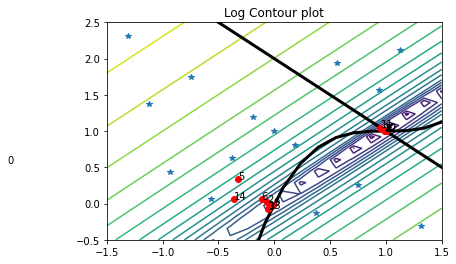

In [ ]:
constraints         = [con1, con2]
obj_f               = rosenbrock
n_iter              = 15
bounds              = [[-1.5,1.5],[-0.5,2.5]]
samples_number      = 15
data                = ['int', bounds, samples_number]

N_GP_opt     = N_GP_RTO(obj_f, constraints, n_iter, data, np.array(bounds), 
                        multi_opt=10, multi_hyper=5, store_data=True)
X_opt, y_opt = N_GP_opt.RTO_routine()

# Plot a sin curve using the x and y axes.
n_points = 20
x_1      = np.linspace(-1.5,1.5, n_points)
x_2      = np.linspace(-0.5,2.5, n_points)
x        = [[x,y] for x in x_1 for y in x_2]
x        = np.array(x)
x        = x.T

# --- plotting functions --- #
# plotting objective
def rosenbrock_plot(x):
    x = x.squeeze()
    if len(x.shape) == 1:
        #return sum([100*(x[i+1]-x[i])**2 + (1-x[i])**2 for i in range(x.shape[0]-1) ])
        return np.log(sum([100*(x[i+1]-x[i])**2 + (1-x[i])**2 for i in range(x.shape[0]-1) ]) ) # notice this makes a difference
    else:
        return 100*(x[1,:]-x[0,:])**2 + (1-x[0,:])**2    
f = rosenbrock_plot(x)
# plotting constraint g1

def con2(x,y):
    #g2 = x + y - 3.
    g2 = (x - 1.)**3 - y + 1
    return -g2
g1x2_plot = [2-x for x in x_1]
# plotting constraint g2
g2x2_plot = [(x - 1.)**3+1 for x in x_1]

# Contour plot
f_copy = f.reshape((n_points,n_points),order='F')

fig, ax = plt.subplots()
CS = ax.contour(x_1, x_2, np.log(f_copy), 20)
ax.plot(x_1,g1x2_plot, 'black', linewidth=3)
ax.plot(x_1,g2x2_plot, 'black', linewidth=3)
ax.plot(X_opt[samples_number:,0], X_opt[samples_number:,1], 'ro')
ax.plot(X_opt[:samples_number,0], X_opt[:samples_number,1], '*')
for i in range(X_opt[samples_number:,:].shape[0]):
    plt.text(X_opt[samples_number+i,0], X_opt[samples_number+i,1], str(i))
#ax.clabel(CS, fontsize=10)
ax.set_title('Log Contour plot')
plt.axis([-1.5,1.5, -0.5,2.5])
plt.show()

##References

*   [1] E. del Rio Chanona, J. Alves Graciano, Bradford, B. Chachuat, 2021. Real-time optimization meets Bayesian optimization and derivative-free optimization: A tale of modifier adaptation. Computers & Chemical Engineering, 147, 107249.
*   [2] E. del Rio Chanona, P. Petsagkourakis, E. Bradford, J. Alves Graciano, Bradford, B. Chachuat, 2019. Modifier-Adaptation
Schemes Employing Gaussian Processes and Trust Regions for Real-Time Optimization. IFACPapersOnLine.
*   [3] D. R. Jones, M. Schonlau, and W. J. Welch, “Efficient global optimization of expensive black-box functions,” Journal of Global optimization, vol. 13, no. 4, pp. 455–492, 1998.